<a href="https://colab.research.google.com/github/ptsurko/ml-notebooks/blob/master/C4_Week_3_Exercise_Question.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install tf-nightly-2.0-preview


     |████████████████████████████████| 95.2MB 104kB/s 
     |████████████████████████████████| 450kB 48.5MB/s 
     |████████████████████████████████| 3.8MB 50.6MB/s 
     |████████████████████████████████| 81kB 13.0MB/s 
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.8.2 which is incompatible.
ERROR: tb-nightly 2.1.0a20191206 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2


In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.0.0-dev20191002


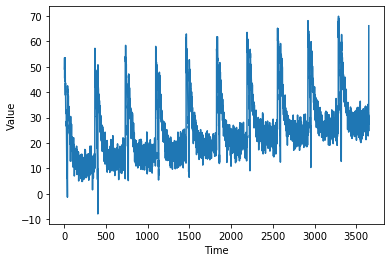

In [0]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(10 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.005
noise_level = 3

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=51)

split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 128
shuffle_buffer_size = 1000

plot_series(time, series)

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

#DNN

In [0]:
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(30, input_shape=(window_size,), activation="relu"),
  tf.keras.layers.Dense(20, activation='relu'),
  tf.keras.layers.Dense(10, activation='relu'),
  tf.keras.layers.Dense(1),
])

model.compile(loss='mae',
              optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9))

history = model.fit(dataset, epochs=100, verbose=0)

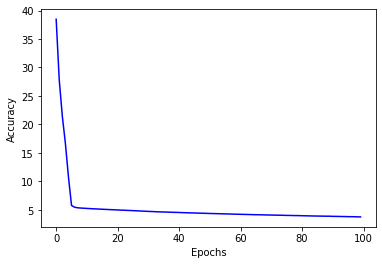

In [0]:
loss=history.history['loss']

plt.plot(range(len(loss)), loss, 'b')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

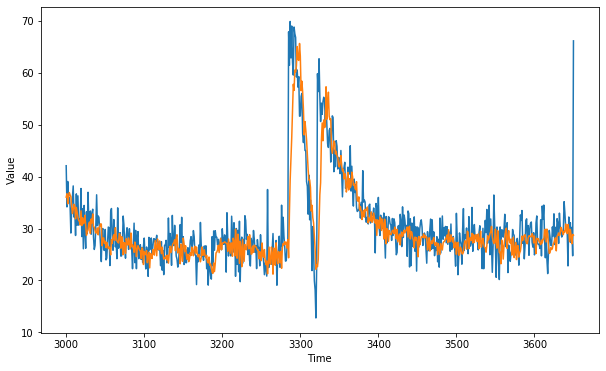

In [0]:
forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [0]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

# YOUR RESULT HERE SHOULD BE LESS THAN 4

3.3089564

# RNN

In [0]:
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                         input_shape=[None]),
  tf.keras.layers.SimpleRNN(units=20, return_sequences=True),
  tf.keras.layers.SimpleRNN(units=20),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=1)

Epoch 1/100
24/24 [==============================] - 1s 61ms/step - loss: 111.2896 - mae: 111.6833
Epoch 2/100
24/24 [==============================] - 0s 14ms/step - loss: 110.3877 - mae: 110.8621
Epoch 3/100
24/24 [==============================] - 0s 16ms/step - loss: 109.3853 - mae: 109.8415
Epoch 4/100
24/24 [==============================] - 0s 15ms/step - loss: 108.2051 - mae: 108.7055
Epoch 5/100
24/24 [==============================] - 0s 14ms/step - loss: 106.9697 - mae: 107.4535
Epoch 6/100
24/24 [==============================] - 0s 15ms/step - loss: 105.5375 - mae: 106.0792
Epoch 7/100
24/24 [==============================] - 0s 15ms/step - loss: 104.1249 - mae: 104.5741
Epoch 8/100
24/24 [==============================] - 0s 15ms/step - loss: 102.5188 - mae: 102.9281
Epoch 9/100
24/24 [==============================] - 0s 17ms/step - loss: 100.6247 - mae: 101.1302
Epoch 10/100
24/24 [==============================] - 0s 16ms/step - loss: 98.6291 - mae: 99.1734
Epoch 11/10

[1e-08, 0.01, 0, 30]

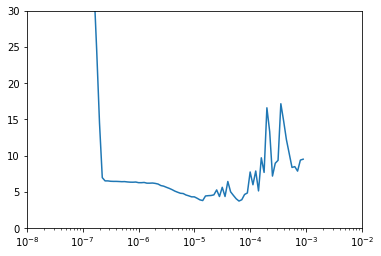

In [0]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-2, 0, 30])

# FROM THIS PICK A LEARNING RATE

In [0]:
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                         input_shape=[None]),
  tf.keras.layers.SimpleRNN(units=40, return_sequences=True),
  tf.keras.layers.SimpleRNN(units=40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9),
              metrics=["mae"])
history = model.fit(dataset,epochs=200,verbose=1)
                                                            
# FIND A MODEL AND A LR THAT TRAINS TO AN MAE < 3                                                          

Epoch 1/200
24/24 [==============================] - 1s 62ms/step - loss: 39.8164 - mae: 41.0777
Epoch 2/200
24/24 [==============================] - 0s 20ms/step - loss: 10.0478 - mae: 10.7061
Epoch 3/200
24/24 [==============================] - 0s 19ms/step - loss: 5.7640 - mae: 6.2860
Epoch 4/200
24/24 [==============================] - 0s 19ms/step - loss: 4.5269 - mae: 5.0371
Epoch 5/200
24/24 [==============================] - 0s 17ms/step - loss: 4.0446 - mae: 4.5550
Epoch 6/200
24/24 [==============================] - 0s 19ms/step - loss: 3.6598 - mae: 4.1494
Epoch 7/200
24/24 [==============================] - 0s 18ms/step - loss: 3.5891 - mae: 4.0479
Epoch 8/200
24/24 [==============================] - 0s 18ms/step - loss: 3.2223 - mae: 3.6787
Epoch 9/200
24/24 [==============================] - 0s 18ms/step - loss: 3.1419 - mae: 3.6248
Epoch 10/200
24/24 [==============================] - 0s 20ms/step - loss: 3.1674 - mae: 3.6181
Epoch 11/200
24/24 [=========================

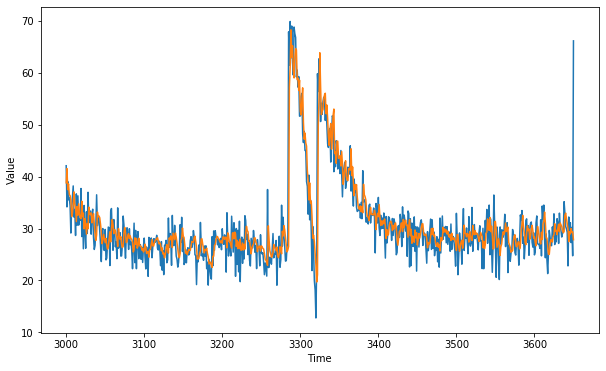

In [0]:
forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [0]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

# YOUR RESULT HERE SHOULD BE LESS THAN 4

3.0528255

# LSTM

In [0]:
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=1)

Epoch 1/100
24/24 [==============================] - 5s 194ms/step - loss: 8.7707 - mae: 9.2208
Epoch 2/100
24/24 [==============================] - 1s 48ms/step - loss: 8.5239 - mae: 9.0773
Epoch 3/100
24/24 [==============================] - 1s 47ms/step - loss: 8.3646 - mae: 8.9089
Epoch 4/100
24/24 [==============================] - 1s 50ms/step - loss: 8.2335 - mae: 8.7447
Epoch 5/100
24/24 [==============================] - 1s 50ms/step - loss: 8.0565 - mae: 8.5836
Epoch 6/100
24/24 [==============================] - 1s 49ms/step - loss: 7.8636 - mae: 8.4329
Epoch 7/100
24/24 [==============================] - 1s 50ms/step - loss: 7.7826 - mae: 8.2943
Epoch 8/100
24/24 [==============================] - 1s 52ms/step - loss: 7.7182 - mae: 8.1675
Epoch 9/100
24/24 [==============================] - 1s 49ms/step - loss: 7.5418 - mae: 8.0627
Epoch 10/100
24/24 [==============================] - 1s 49ms/step - loss: 7.4675 - mae: 7.9611
Epoch 11/100
24/24 [============================

In [0]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-2, 0, 30])

# FROM THIS PICK A LEARNING RATE

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

model.compile(loss="mse",
              optimizer=tf.keras.optimizers.SGD(lr=1e-3, 
                                                momentum=0.9),
              metrics=["mae"])
history = model.fit(dataset,epochs=100,verbose=1)
                                                            
# FIND A MODEL AND A LR THAT TRAINS TO AN MAE < 3                                                          

Epoch 1/500
24/24 [==============================] - 10s 412ms/step - loss: nan - mae: nan
Epoch 2/500
24/24 [==============================] - 1s 56ms/step - loss: nan - mae: nan
Epoch 3/500
24/24 [==============================] - 1s 55ms/step - loss: nan - mae: nan
Epoch 4/500
24/24 [==============================] - 1s 55ms/step - loss: nan - mae: nan
Epoch 5/500
24/24 [==============================] - 1s 57ms/step - loss: nan - mae: nan
Epoch 6/500
24/24 [==============================] - 1s 55ms/step - loss: nan - mae: nan
Epoch 7/500
24/24 [==============================] - 1s 54ms/step - loss: nan - mae: nan
Epoch 8/500
24/24 [==============================] - 1s 55ms/step - loss: nan - mae: nan
Epoch 9/500
24/24 [==============================] - 1s 56ms/step - loss: nan - mae: nan
Epoch 10/500
24/24 [==============================] - 1s 55ms/step - loss: nan - mae: nan
Epoch 11/500
24/24 [==============================] - 1s 55ms/step - loss: nan - mae: nan
Epoch 12/500
24/2

KeyboardInterrupt: ignored

In [0]:
forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [0]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

# YOUR RESULT HERE SHOULD BE LESS THAN 4

In [0]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()